In [1]:
!nvidia-smi


Fri May 19 17:10:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# New Section

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:

my_folder_path = '/content/drive/MyDrive/Deep_Steganography_main/train'
print(my_folder_path)

/content/drive/MyDrive/Deep_Steganography_main/train


In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
from datetime import datetime 

start_time = datetime.now() 

import time
time.sleep(3)


In [6]:

import warnings
warnings.filterwarnings('ignore')

In [7]:
#import glob
#from PIL import Image,ImageOps
#import random
#import os
#import time
#from datetime import datetime
#from os.path import join

#os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

#import logging
#logging.getLogger("tensorflow").setLevel(logging.WARNING)

#import tensorflow.compat.v1 as tf

#gpu_devices = tf.config.experimental.list_physical_devices('GPU')
#if len(gpu_devices) > 0:
#    tf.config.experimental.set_memory_growth(gpu_devices[0], True)

#print("Num GPUs Available: ", len(gpu_devices))

import glob
from PIL import Image,ImageOps
import random
import os
import time
from datetime import datetime
from os.path import join

os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import logging
logging.getLogger("tensorflow").setLevel(logging.WARNING)

import tensorflow.compat.v1 as tf

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices) > 0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)

print("Num GPUs Available: ", len(gpu_devices))


Num GPUs Available:  1


In [8]:
TRAIN_PATH = '/content/drive/MyDrive/Deep_Steganography_main/Deep_Steganography_main/train/*'
LOGS_Path = "./logs/"
CHECKPOINTS_PATH = './checkpoints/'


BATCH_SIZE = 4
LEARNING_RATE = .0001
BETA = .75

EXP_NAME = f"beta_{BETA}"

In [9]:
test_path= '/content/drive/MyDrive/stego_images/*'
test_files = glob.glob(test_path)

In [10]:
print("Total no. of dataset: ", len(glob.glob(TRAIN_PATH)))
print("Total no. of dataset: ", len(glob.glob(test_path)))

Total no. of dataset:  50
Total no. of dataset:  812


In [11]:
test_files_list = glob.glob(test_path)

In [12]:
files_list = glob.glob(TRAIN_PATH)

def normalize_batch(imgs):
    return (imgs -  np.array([0.485, 0.456, 0.406])) /np.array([0.229, 0.224, 0.225])
                                                        
def denormalize_batch(imgs,should_clip=True):
    imgs= (imgs * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
    
    if should_clip:
        imgs= np.clip(imgs,0,1)
    return imgs

def get_img_batch(files_list,batch_size=32,size=(224,224),should_normalise=True):
   
    batch_cover = []
    batch_secret = []

    for i in range(batch_size):
        img_secret_path = random.choice(files_list)
        img_cover_path = random.choice(files_list)
        
        img_secret = Image.open(img_secret_path).convert("RGB")
        img_cover = Image.open(img_cover_path).convert("RGB")

        img_secret = np.array(ImageOps.fit(img_secret,size),dtype=np.float32)
        img_cover = np.array(ImageOps.fit(img_cover,size),dtype=np.float32)
        
        img_secret /= 255.
        img_cover /= 255.
        
        batch_cover.append(img_cover)
        batch_secret.append(img_secret)
        
    batch_cover,batch_secret = np.array(batch_cover) , np.array(batch_secret)
    
    if should_normalise:
        batch_cover = normalize_batch(batch_cover)
        batch_secret = normalize_batch(batch_secret)

    return batch_cover,batch_secret

In [13]:
def get_prep_network_op(secret_tensor):
    
    with tf.variable_scope('prep_net'):
        
        with tf.variable_scope("3x3_conv_branch"):
            conv_3x3 = tf.layers.conv2d(inputs=secret_tensor,filters=50,kernel_size=6,padding='same',name="1",activation=tf.nn.relu)
            conv_3x3 = tf.layers.conv2d(inputs=conv_3x3,filters=50,kernel_size=6,padding='same',name="2",activation=tf.nn.relu)
            conv_3x3 = tf.layers.conv2d(inputs=conv_3x3,filters=50,kernel_size=6,padding='same',name="3",activation=tf.nn.relu)
            conv_3x3 = tf.layers.conv2d(inputs=conv_3x3,filters=50,kernel_size=6,padding='same',name="4",activation=tf.nn.relu)
            conv_3x3 = tf.layers.conv2d(inputs=conv_3x3,filters=50,kernel_size=6,padding='same',name="5",activation=tf.nn.relu)
            
        with tf.variable_scope("4x4_conv_branch"):
            conv_4x4 = tf.layers.conv2d(inputs=secret_tensor,filters=50,kernel_size=4,padding='same',name="1",activation=tf.nn.relu)
            conv_4x4 = tf.layers.conv2d(inputs=conv_4x4,filters=50,kernel_size=4,padding='same',name="2",activation=tf.nn.relu)           
            conv_4x4 = tf.layers.conv2d(inputs=conv_4x4,filters=50,kernel_size=4,padding='same',name="3",activation=tf.nn.relu)
            conv_4x4 = tf.layers.conv2d(inputs=conv_4x4,filters=50,kernel_size=4,padding='same',name="4",activation=tf.nn.relu)
            conv_4x4 = tf.layers.conv2d(inputs=conv_4x4,filters=50,kernel_size=4,padding='same',name="5",activation=tf.nn.relu)

        with tf.variable_scope("5x5_conv_branch"):
            conv_5x5 = tf.layers.conv2d(inputs=secret_tensor,filters=50,kernel_size=5,padding='same',name="1",activation=tf.nn.relu)
            conv_5x5 = tf.layers.conv2d(inputs=conv_5x5,filters=50,kernel_size=5,padding='same',name="2",activation=tf.nn.relu)           
            conv_5x5 = tf.layers.conv2d(inputs=conv_5x5,filters=50,kernel_size=5,padding='same',name="3",activation=tf.nn.relu)
            conv_4x4 = tf.layers.conv2d(inputs=conv_4x4,filters=50,kernel_size=4,padding='same',name="4",activation=tf.nn.relu)
            conv_4x4 = tf.layers.conv2d(inputs=conv_4x4,filters=50,kernel_size=4,padding='same',name="5",activation=tf.nn.relu)
            
        concat_1 = tf.concat([conv_3x3],axis=3,name='concat_1')
        
        conv_5x5 = tf.layers.conv2d(inputs=concat_1,filters=50,kernel_size=5,padding='same',name="final_5x5",activation=tf.nn.relu)
        conv_4x4 = tf.layers.conv2d(inputs=concat_1,filters=50,kernel_size=4,padding='same',name="final_4x4",activation=tf.nn.relu)
        conv_3x3 = tf.layers.conv2d(inputs=concat_1,filters=50,kernel_size=6,padding='same',name="final_3x3",activation=tf.nn.relu)
        
        concat_final = tf.concat([conv_3x3],axis=3,name='concat_final')

        return concat_final

    
def get_hiding_network_op(cover_tensor,prep_output):
    
    with tf.variable_scope('hide_net'):
        concat_input = tf.concat([cover_tensor,prep_output],axis=3,name='images_features_concat')
        
        with tf.variable_scope("3x3_conv_branch"):
            conv_3x3 = tf.layers.conv2d(inputs=concat_input,filters=50,kernel_size=6,padding='same',name="1",activation=tf.nn.relu)
            conv_3x3 = tf.layers.conv2d(inputs=conv_3x3,filters=50,kernel_size=6,padding='same',name="2",activation=tf.nn.relu)
            conv_3x3 = tf.layers.conv2d(inputs=conv_3x3,filters=50,kernel_size=6,padding='same',name="3",activation=tf.nn.relu)
            conv_3x3 = tf.layers.conv2d(inputs=conv_3x3,filters=50,kernel_size=6,padding='same',name="4",activation=tf.nn.relu)
            conv_3x3 = tf.layers.conv2d(inputs=conv_3x3,filters=50,kernel_size=6,padding='same',name="5",activation=tf.nn.relu)
            
        with tf.variable_scope("4x4_conv_branch"):
            conv_4x4 = tf.layers.conv2d(inputs=concat_input,filters=50,kernel_size=4,padding='same',name="1",activation=tf.nn.relu)
            conv_4x4 = tf.layers.conv2d(inputs=conv_4x4,filters=50,kernel_size=4,padding='same',name="2",activation=tf.nn.relu)          
            conv_4x4 = tf.layers.conv2d(inputs=conv_4x4,filters=50,kernel_size=4,padding='same',name="3",activation=tf.nn.relu)
            conv_4x4 = tf.layers.conv2d(inputs=conv_4x4,filters=50,kernel_size=4,padding='same',name="4",activation=tf.nn.relu)
            conv_4x4 = tf.layers.conv2d(inputs=conv_4x4,filters=50,kernel_size=4,padding='same',name="5",activation=tf.nn.relu)

        with tf.variable_scope("5x5_conv_branch"):
            conv_5x5 = tf.layers.conv2d(inputs=concat_input,filters=50,kernel_size=5,padding='same',name="1",activation=tf.nn.relu)
            conv_5x5 = tf.layers.conv2d(inputs=conv_5x5,filters=50,kernel_size=5,padding='same',name="2",activation=tf.nn.relu)          
            conv_5x5 = tf.layers.conv2d(inputs=conv_5x5,filters=50,kernel_size=5,padding='same',name="3",activation=tf.nn.relu)
            conv_5x5 = tf.layers.conv2d(inputs=conv_5x5,filters=50,kernel_size=5,padding='same',name="4",activation=tf.nn.relu)
            conv_5x5 = tf.layers.conv2d(inputs=conv_5x5,filters=50,kernel_size=5,padding='same',name="5",activation=tf.nn.relu)
            
        concat_1 = tf.concat([conv_3x3],axis=3,name='concat_1')
        
        conv_5x5 = tf.layers.conv2d(inputs=concat_1,filters=50,kernel_size=5,padding='same',name="final_5x5",activation=tf.nn.relu)
        conv_4x4 = tf.layers.conv2d(inputs=concat_1,filters=50,kernel_size=4,padding='same',name="final_4x4",activation=tf.nn.relu)
        conv_3x3 = tf.layers.conv2d(inputs=concat_1,filters=50,kernel_size=6,padding='same',name="final_3x3",activation=tf.nn.relu)
        
        concat_final = tf.concat([conv_3x3],axis=3,name='concat_final')
        output = tf.layers.conv2d(inputs=concat_final,filters=3,kernel_size=1,padding='same',name='output')
        
        return output
    
        
        
def get_reveal_network_op(container_tensor):
    
    with tf.variable_scope('reveal_net'):
        
        with tf.variable_scope("3x3_conv_branch"):
            conv_3x3 = tf.layers.conv2d(inputs=container_tensor,filters=50,kernel_size=6,padding='same',name="1",activation=tf.nn.relu)
            conv_3x3 = tf.layers.conv2d(inputs=conv_3x3,filters=50,kernel_size=6,padding='same',name="2",activation=tf.nn.relu)
            conv_3x3 = tf.layers.conv2d(inputs=conv_3x3,filters=50,kernel_size=6,padding='same',name="3",activation=tf.nn.relu)
            conv_3x3 = tf.layers.conv2d(inputs=conv_3x3,filters=50,kernel_size=6,padding='same',name="4",activation=tf.nn.relu)
            conv_3x3 = tf.layers.conv2d(inputs=conv_3x3,filters=50,kernel_size=6,padding='same',name="5",activation=tf.nn.relu)
            
        with tf.variable_scope("4x4_conv_branch"):
            conv_4x4 = tf.layers.conv2d(inputs=container_tensor,filters=50,kernel_size=4,padding='same',name="1",activation=tf.nn.relu)
            conv_4x4 = tf.layers.conv2d(inputs=conv_4x4,filters=50,kernel_size=4,padding='same',name="2",activation=tf.nn.relu)          
            conv_4x4 = tf.layers.conv2d(inputs=conv_4x4,filters=50,kernel_size=4,padding='same',name="3",activation=tf.nn.relu)
            conv_4x4 = tf.layers.conv2d(inputs=conv_4x4,filters=50,kernel_size=4,padding='same',name="4",activation=tf.nn.relu)
            conv_4x4 = tf.layers.conv2d(inputs=conv_4x4,filters=50,kernel_size=4,padding='same',name="5",activation=tf.nn.relu)

        with tf.variable_scope("5x5_conv_branch"):
            conv_5x5 = tf.layers.conv2d(inputs=container_tensor,filters=50,kernel_size=5,padding='same',name="1",activation=tf.nn.relu)
            conv_5x5 = tf.layers.conv2d(inputs=conv_5x5,filters=50,kernel_size=5,padding='same',name="2",activation=tf.nn.relu)           
            conv_5x5 = tf.layers.conv2d(inputs=conv_5x5,filters=50,kernel_size=5,padding='same',name="3",activation=tf.nn.relu)
            conv_5x5 = tf.layers.conv2d(inputs=conv_5x5,filters=50,kernel_size=5,padding='same',name="4",activation=tf.nn.relu)
            conv_5x5 = tf.layers.conv2d(inputs=conv_5x5,filters=50,kernel_size=5,padding='same',name="5",activation=tf.nn.relu)
            
        concat_1 = tf.concat([conv_3x3],axis=3,name='concat_1')
        
        conv_5x5 = tf.layers.conv2d(inputs=concat_1,filters=50,kernel_size=5,padding='same',name="final_5x5",activation=tf.nn.relu)
        conv_4x4 = tf.layers.conv2d(inputs=concat_1,filters=50,kernel_size=4,padding='same',name="final_4x4",activation=tf.nn.relu)
        conv_3x3 = tf.layers.conv2d(inputs=concat_1,filters=50,kernel_size=6,padding='same',name="final_3x3",activation=tf.nn.relu)
        
        concat_final = tf.concat([conv_3x3],axis=3,name='concat_final')
    
    output = tf.layers.conv2d(inputs=concat_final,filters=3,kernel_size=1,padding='same',name='output')

    return output

def get_noise_layer_op(tensor,std=.1):
    with tf.variable_scope("noise_layer"):
        return tensor + tf.random_normal(shape=tf.shape(tensor), mean=0.0, stddev=std, dtype=tf.float32) 
    
def get_loss_op(secret_true,secret_pred,cover_true,cover_pred,beta=.5):
    
    with tf.variable_scope("losses"):
        beta = tf.constant(beta,name="beta")
        secret_mse = tf.losses.mean_squared_error(secret_true,secret_pred)
        cover_mse = tf.losses.mean_squared_error(cover_true,cover_pred)
        final_loss = cover_mse + beta*secret_mse
        return final_loss , secret_mse , cover_mse 

def get_tensor_to_img_op(tensor):
    with tf.variable_scope("",reuse=True):
        t = tensor*tf.convert_to_tensor([0.229, 0.224, 0.225]) + tf.convert_to_tensor([0.485, 0.456, 0.406])
        return tf.clip_by_value(t,0,1)

In [14]:
def prepare_training_graph(secret_tensor,cover_tensor,global_step_tensor):
    
    prep_output_op = get_prep_network_op(secret_tensor)
    hiding_output_op = get_hiding_network_op(cover_tensor=cover_tensor,prep_output=prep_output_op)
    noise_add_op = get_noise_layer_op(hiding_output_op)
    reveal_output_op = get_reveal_network_op(noise_add_op)
    
    loss_op,secret_loss_op,cover_loss_op = get_loss_op(secret_tensor,reveal_output_op,cover_tensor,hiding_output_op,beta=BETA)
    
    minimize_op = tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss_op,global_step=global_step_tensor)
    
    tf.summary.scalar('loss', loss_op,family='train')
    tf.summary.scalar('reveal_net_loss', secret_loss_op,family='train')
    tf.summary.scalar('cover_net_loss', cover_loss_op,family='train')

    tf.summary.image('secret',get_tensor_to_img_op(secret_tensor),max_outputs=1,family='train')
    tf.summary.image('cover',get_tensor_to_img_op(cover_tensor),max_outputs=1,family='train')
    tf.summary.image('hidden',get_tensor_to_img_op(hiding_output_op),max_outputs=1,family='train')
    tf.summary.image('hidden_noisy',get_tensor_to_img_op(noise_add_op),max_outputs=1,family='train')
    tf.summary.image('revealed',get_tensor_to_img_op(reveal_output_op),max_outputs=1,family='train')

    merged_summary_op = tf.summary.merge_all()
    
    return minimize_op, merged_summary_op

In [15]:
def prepare_test_graph(secret_tensor,cover_tensor):
    with tf.variable_scope("",reuse=True):
    
        prep_output_op = get_prep_network_op(secret_tensor)
        hiding_output_op = get_hiding_network_op(cover_tensor=cover_tensor,prep_output=prep_output_op)
        reveal_output_op = get_reveal_network_op(hiding_output_op)
        
        loss_op,secret_loss_op,cover_loss_op = get_loss_op(secret_tensor,reveal_output_op,cover_tensor,hiding_output_op)

        tf.summary.scalar('loss', loss_op,family='test')
        tf.summary.scalar('reveal_net_loss', secret_loss_op,family='test')
        tf.summary.scalar('cover_net_loss', cover_loss_op,family='test')

        tf.summary.image('secret',get_tensor_to_img_op(secret_tensor),max_outputs=1,family='test')
        tf.summary.image('cover',get_tensor_to_img_op(cover_tensor),max_outputs=1,family='test')
        tf.summary.image('hidden',get_tensor_to_img_op(hiding_output_op),max_outputs=1,family='test')
        tf.summary.image('revealed',get_tensor_to_img_op(reveal_output_op),max_outputs=1,family='test')

        merged_summary_op = tf.summary.merge_all()

        return merged_summary_op

In [16]:
def prepare_deployment_graph(secret_tensor,cover_tensor,covered_tensor):
    with tf.variable_scope("",reuse=True):

        prep_output_op = get_prep_network_op(secret_tensor)
        hiding_output_op = get_hiding_network_op(cover_tensor=cover_tensor,prep_output=prep_output_op)

        reveal_output_op = get_reveal_network_op(covered_tensor)

        return hiding_output_op ,  reveal_output_op

In [17]:
sess = tf.InteractiveSession(graph=tf.Graph())

In [18]:
secret_tensor = tf.placeholder(shape=[None,224,224,3],dtype=tf.float32,name="input_prep")
cover_tensor = tf.placeholder(shape=[None,224,224,3],dtype=tf.float32,name="input_hide")
global_step_tensor = tf.Variable(0, trainable=False, name='global_step')

train_op , summary_op = prepare_training_graph(secret_tensor,cover_tensor,global_step_tensor)

writer = tf.summary.FileWriter(join(LOGS_Path,EXP_NAME),sess.graph)

test_op = prepare_test_graph(secret_tensor,cover_tensor)

covered_tensor = tf.placeholder(shape=[None,224,224,3],dtype=tf.float32,name="deploy_covered")
deploy_hide_image_op , deploy_reveal_image_op = prepare_deployment_graph(secret_tensor,cover_tensor,covered_tensor)

In [19]:
saver = tf.train.Saver(max_to_keep=1)
sess.run(tf.global_variables_initializer())

In [20]:
total_steps = len(files_list)//BATCH_SIZE + 1
BATCH_SIZE

4

In [21]:

print(files_list)

['/content/drive/MyDrive/Deep_Steganography_main/Deep_Steganography_main/train/train_image_png_10.png', '/content/drive/MyDrive/Deep_Steganography_main/Deep_Steganography_main/train/train_image_png_26.png', '/content/drive/MyDrive/Deep_Steganography_main/Deep_Steganography_main/train/train_image_png_19.png', '/content/drive/MyDrive/Deep_Steganography_main/Deep_Steganography_main/train/train_image_png_36.png', '/content/drive/MyDrive/Deep_Steganography_main/Deep_Steganography_main/train/train_image_png_9.png', '/content/drive/MyDrive/Deep_Steganography_main/Deep_Steganography_main/train/train_image_png_32.png', '/content/drive/MyDrive/Deep_Steganography_main/Deep_Steganography_main/train/train_image_png_1.png', '/content/drive/MyDrive/Deep_Steganography_main/Deep_Steganography_main/train/train_image_png_22.png', '/content/drive/MyDrive/Deep_Steganography_main/Deep_Steganography_main/train/train_image_png_11.png', '/content/drive/MyDrive/Deep_Steganography_main/Deep_Steganography_main/tr

In [33]:
for ep in range(50):
    for step in range(total_steps):
        covers,secrets = get_img_batch(files_list=files_list,batch_size=BATCH_SIZE)
        sess.run([train_op],feed_dict={"input_prep:0":secrets,"input_hide:0":covers})
        
        if step % 10 ==0 :
            
            summary,global_step = sess.run([summary_op,global_step_tensor],feed_dict={"input_prep:0":secrets,"input_hide:0":covers})
            writer.add_summary(summary,global_step)
            
        if step % 100 ==0 :
            
            covers,secrets = get_img_batch(files_list=files_list,batch_size=1)
            summary,global_step = sess.run([test_op,global_step_tensor],feed_dict={"input_prep:0":secrets,"input_hide:0":covers})
            writer.add_summary(summary,global_step)

    
    save_path = saver.save(sess, join(CHECKPOINTS_PATH,EXP_NAME+".chkp"),global_step=global_step)

Instructions for updating:
Use standard file APIs to delete files with this prefix.


In [ ]:
import tensorflow as tf

# Assuming you have defined your model architecture, optimizer, and loss

# ...

# Define the activation function
activation = tf.nn.relu

# ...

for ep in range(100):
    for step in range(total_steps):
        covers, secrets = get_img_batch(files_list=files_list, batch_size=BATCH_SIZE)
        loss_value = sess.run([train_op],feed_dict={"input_prep:0":secrets,"input_hide:0":covers})

        if step % 10 == 0:
            summary, global_step = sess.run([summary_op, global_step_tensor], feed_dict={"input_prep:0": secrets, "input_hide:0": covers})
            writer.add_summary(summary, global_step)

        if step % 100 == 0:
            covers, secrets = get_img_batch(files_list=files_list, batch_size=1)
            summary, global_step = sess.run([test_op, global_step_tensor], feed_dict={"input_prep:0": secrets, "input_hide:0": covers})
            writer.add_summary(summary, global_step)

    save_path = saver.save(sess, join(CHECKPOINTS_PATH, EXP_NAME + ".chkp"), global_step=global_step)


In [45]:
writer.close()

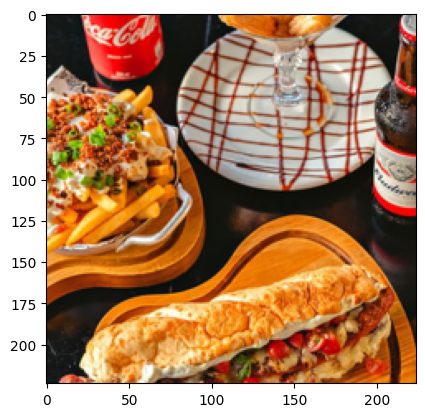

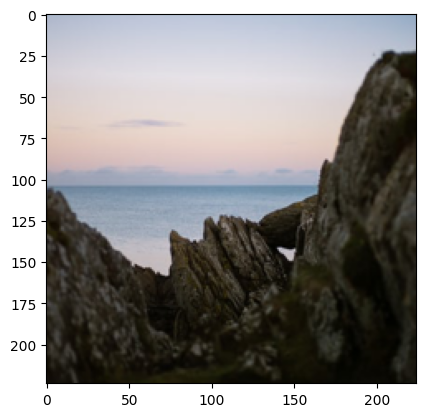

In [46]:
covers,secrets = get_img_batch(files_list=test_files_list,batch_size=1)

cover = covers.squeeze()
secret = secrets.squeeze()
plt.imshow(denormalize_batch(cover))
plt.show()
plt.imshow(denormalize_batch(secret))
plt.show()

C:\Users\YAJAS\OneDrive\Desktop\Output/hidden_image.png


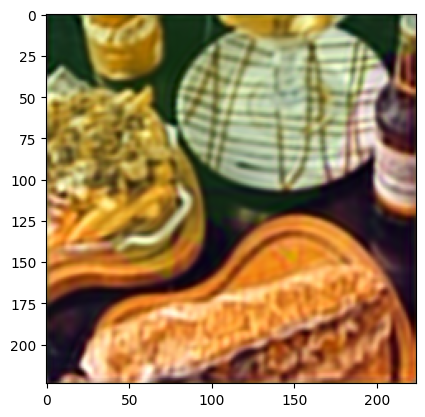

In [47]:
import os
import numpy as np
import matplotlib.pyplot as plt
hidden = sess.run(deploy_hide_image_op,feed_dict={'input_prep:0':secrets,'input_hide:0':covers})

folder_path = r'C:\Users\YAJAS\OneDrive\Desktop\Output'

# Create the folder if it doesn't exist
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
                                                          
# Normalize the image array to the range [0, 255]         
hidden_normalized = np.uint8((hidden + 1) * 127.5)        
                                                          
# Save the image                                          
image_path = os.path.join(folder_path, 'hidden_image.png')
plt.imsave(image_path, hidden_normalized.squeeze())
print(image_path)
plt.imshow(denormalize_batch(hidden.squeeze()))

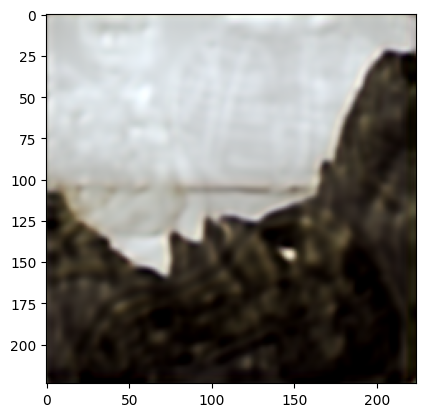

In [48]:
revealed = sess.run(deploy_reveal_image_op,feed_dict={'deploy_covered:0':hidden})

plt.imshow(denormalize_batch(revealed.squeeze()))

In [49]:
import numpy as np

covers, secrets = get_img_batch(files_list=files_list, batch_size=1)
cover = covers.squeeze()
secret = secrets.squeeze()

# Assuming the images are already in the appropriate format for display

# Display the cover and secret images


# Calculate RMSE
rmse = np.sqrt(np.mean(np.square(cover - secret)))
print("RMSE:", rmse)



RMSE: 1.8242042607617643


In [ ]:
import tkinter as tk
from tkinter import filedialog

def open_file():
    file_path = filedialog.askopenfilename()
    print("Selected file:", file_path)

def save_file():
    file_path = filedialog.asksaveasfilename()
    print("Save file path:", file_path)

root = tk.Tk()
root.title("GUI Example")

# Create and pack widgets
open_button = tk.Button(root, text="Open File", command=open_file)
open_button.pack()

save_button = tk.Button(root, text="Save File", command=save_file)
save_button.pack()

exit_button = tk.Button(root, text="Exit", command=root.destroy)
exit_button.pack()

root.mainloop()


TclError: ignored

In [ ]:
import os
import skimage
from skimage.measure import compare_ssim

# Path to the directory containing the test images
test_dir = "path_to_test_images_directory"

# List all image files in the test directory
image_files = [f for f in os.listdir(test_dir) if f.endswith('.jpg') or f.endswith('.png')]

# Calculate SSIM for each image
for image_file in image_files:
    image_path = os.path.join(test_dir, image_file)
    image = skimage.io.imread(image_path, as_gray=True)  # Convert the image to grayscale
    ssim_score = compare_ssim(image, reference_image, data_range=image.max() - image.min())
    print(f"SSIM for {image_file}: {ssim_score}")


ImportError: ignored